In [93]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import datetime

from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag

import cvxpy as cp 

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List, Tuple

"""
Own packages
"""
import codelib.portfolio_optimization.risk_metrics as rm 
import codelib.portfolio_optimization.diversification as dm

from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.portfolio_optimization.mean_variance import portfolio_variance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exercises - Week 10


## Problem 1: Variable transaction costs

Consider the asset universe defined by the correlation matrix

$$
C = \begin{pmatrix} 1.0 & 0.85 & 0.5 & 0.45 \\
0.85 & 1.0 & 0.5 & 0.45 \\
0.5 & 0.5 & 1.0 & 0.9 \\
0.45 & 0.45 & 0.9 & 1.0 \end{pmatrix}
$$

the expected returns $\mu = (3.2, 3.12, 8.0, 8.2)^\top$, and the volatilities $(5.0, 5.0, 22.0, 22.0)^\top$

Assume that the investor initially holds an equally weighted portfolio $w_i^0 = 1/4$, for $i=1,...,4$. 

__Question 1__

We can define the mean-variance problem in terms of changes to the initial weights 

\begin{align*}
	\min_{\mathbf{x}}  \quad & (\mathbf{w}^0 + \mathbf{x})^\top \boldsymbol{\Sigma} (\mathbf{w}^0 + \mathbf{x})\\
	\textrm{s.t.} \quad & \mathbf{x}^\top \mathbf{1} = 0 \\
      & (\mathbf{w}^0 + \mathbf{x})^\top \boldsymbol{\mu} \geq \delta \\
\end{align*}

Find the optimal $\mathbf{x}$ using `CVXPY` with $\delta = 0.045$

__Question 2__

Assume that it is not cost free to trade such that 

\begin{align*}
	\min_{\mathbf{x}}  \quad & (\mathbf{w}^0 + \mathbf{x})^\top \boldsymbol{\Sigma} (\mathbf{w}^0 + \mathbf{x})\\
	\textrm{s.t.} \quad & \mathbf{x}^\top \mathbf{1} + \phi(\mathbf{x})= 0 \\
     & (\mathbf{w}^0 + \mathbf{x})^\top \boldsymbol{\mu} \geq \delta \\
\end{align*}

where $\phi(\mathbf{x}) = \sum_{i=1}^N \phi_i(x_i)$ with 

$$
\phi_i(x_i) = \left\{ \begin{array}{cr} \alpha^{+} x_i, & x_i \geq 0 \\ \alpha^- x_i, & x_i \leq 0 \end{array}\right.
$$

is the variable transaction costs.  Note that we can write 

$$
\phi_i = \alpha^{+} x_i^+ +  \alpha^- x_i^{-}
$$

where $x_i = x_i^{+} - x_i^{-}$ with $x_i^{+}, x_i^{-} \geq 0$. 

Implement the optimization with variable transaction costs when assuming $\alpha^+, \alpha^- = 0.01$. What is the consequence?


### Solution 

__Question 1__

In [94]:
"""
Define inputs 
"""

corr_mat = np.array([[1.0, 0.85, 0.5, 0.45],
                     [0.85, 1.0, 0.5, 0.45],
                     [0.5, 0.5, 1.0, 0.9],
                     [0.45, 0.45, 0.9, 1.0]])

vols = np.array([5.0, 5.0, 22.0, 22.0]) / np.sqrt(12) / 100.0
mu = np.array([3.2, 3.12, 8.0, 8.2]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat, vols)


In [95]:
"""
Define and solve problem 
"""

num_assets = len(mu)

w0 = np.ones(num_assets) / num_assets
delta = 0.045

# define optimization variable 
x = cp.Variable(num_assets)

# define constraints 
constraints = [cp.sum(x) == 0.0, (w0 + x) @ mu >= delta]

# define problem 
prob = cp.Problem(cp.Minimize(cp.quad_form(x + w0, cov_mat)), constraints=constraints)

# solve problem 
prob.solve()

# show x.value
x.value

array([ 0.39738186, -0.16023965, -0.21445942, -0.0226828 ])

In [96]:
# show x.value
w0 + x.value

array([0.64738186, 0.08976035, 0.03554058, 0.2273172 ])

__Question 2__

In [97]:
num_assets = len(mu)

w0 = np.ones(num_assets) / num_assets
delta = 0.045

# transaction costs 
alpha_pos = 0.01
alpha_neg = 0.01

# define optimization variable 
x = cp.Variable(num_assets)
x_pos = cp.Variable(num_assets)
x_neg = cp.Variable(num_assets)

# define constraints 
constraints = [x_pos >= 0.0,
               x_neg >= 0.0,
               cp.sum(x + alpha_pos*x_pos + alpha_neg * x_neg)   <= 0.0,
               x == x_pos - x_neg, 
               (w0 + x) @ mu >= delta]

# define problem 
prob = cp.Problem(cp.Minimize(cp.quad_form(x + w0, cov_mat)), constraints=constraints)

# solve problem 
prob.solve()

# show x.value
x.value

array([ 0.25323001, -0.02672492, -0.21168337, -0.01993748])

In [98]:
# show allocation
w0 + x.value

array([0.50323001, 0.22327508, 0.03831663, 0.23006252])

We trade less! 

## Problem 2: Constraints on the number of uncorrelated bets 

Consider the asset univers: Government bonds, Investment-grade bonds, High-yield bonds, Emerging markets gov. bonds, Equities (developed markets), Equities (Emerging markets), Private equity, Infrastructure, Real Estate, and Hedgefunds. 

$$
\mathbf{R} \sim N(\boldsymbol{\mu}, \boldsymbol{\Sigma})
$$

with correlation matrix 

\begin{equation*}
\mathbf{C} =   \begin{bmatrix}
1.0 &  0.6 &  0.1 &  0.3 & -0.1 & -0.1 & -0.2 & -0.1 & -0.1 & -0.1 \\
0.6 &  1.0 &  0.6 &  0.6 &  0.2 &  0.2 &  0.2 &  0.1 &  0.1 &  0.3 \\ 
0.1 &  0.6 &  1.0 &  0.7 &  0.7 &  0.6 &  0.6 &  0.4 &  0.3 &  0.7 \\
0.3 &  0.6 &  0.7 &  1.0 &  0.5 &  0.6 &  0.4 &  0.2 &  0.2 &  0.5 \\
-0.1 &  0.2 &  0.7 &  0.5 &  1.0 &  0.7 &  0.8 &  0.4 &  0.4 &  0.8 \\
-0.1 &  0.2 &  0.6 &  0.6 &  0.7 &  1.0 &  0.7 &  0.4 &  0.4 &  0.7 \\
-0.2 &  0.2 &  0.6 &  0.4 &  0.8 &  0.7 &  1.0 &  0.4 &  0.4 &  0.7 \\
-0.1 &  0.1 &  0.4 &  0.2 &  0.4 &  0.4 &  0.4 &  1.0 &  0.3 &  0.4 \\
-0.1 &  0.1 &  0.3 &  0.2 &  0.4 &  0.4 &  0.4 &  0.3 &  1.0 &  0.4 \\
-0.1 &  0.3 &  0.7 &  0.5 &  0.8 &  0.7 &  0.7 &  0.4 &  0.4 &  1.0
\end{bmatrix},
\end{equation*}

vector of volatilities 


\begin{equation*}
\mathbf{v} =   \begin{bmatrix}
0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094
\end{bmatrix}^\top,
\end{equation*} 

and expected return
\begin{equation*}
\boldsymbol{\mu} =   \begin{bmatrix}
0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038
\end{bmatrix}^\top 
\end{equation*} 

__Question 1__

Find the minimum-variance portfolio with the budget constraint $\mathbf{w}^\top \mathbf{1} = 1$ and the long-only constraint $\mathbf{w} \geq 0$. 

__Question 2__

A simplistic or naive view of portfolio diversification is to look at the number of constituents in the portfolios or the portfolio weights. One possibility is to use the norm of the portfolio weight vector, $\mathbf{w}$, to determine the Effective Number of Constituents (ENC)  (valid for any $\alpha > 0$ if weights are all positive)

\begin{equation*}
\text{ENC}_{\alpha} (\mathbf{w}) = \Vert \mathbf{w} \Vert_{\alpha}^{\frac{\alpha}{1 - \alpha}} = \left(\sum_{i=1}^N w_i^\alpha \right)^{\frac{1}{1-\alpha}}, \; \; \alpha > 0, \; \alpha \neq 1
\end{equation*}

where $N$ denote the number of assets. If $\alpha = 2$, the diversification measure is equal to the inverse of the \href{https://en.wikipedia.org/wiki/Herfindahl%E2%80%93Hirschman_index}{Herfindahl index}

\begin{equation*}
\text{ENC}_{2} (\mathbf{w}) = \frac{1}{\sum_{i=1}^N w_i^2}
\end{equation*}

In the limiting case when $\alpha \to 1$, we obtain the exponential of the entropy of the distribution of the portfolio weight vector

\begin{equation*}
\text{ENC}_{1} = \exp \left( - \sum_{i=1}^N w_i \ln w_i\right)
\end{equation*}

Calculate the effective number of constituents with $\alpha=1$ and $\alpha=2$. Note the function `codelib.portfolio_optimization.diversification.cal`

__Question 3__

[Meucci (2009), "Managing Diversification"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1358533) defines the _effective  number of uncorrelated bets_. 

The method relies on the choice of $N$ uncorrelated factors whose returns can be expressed as

\begin{equation}
    \mathbf{R}_F = \mathbf{A}^{-1} \mathbf{R}
\end{equation}

where $R$ is the vector of constituents returns and $\mathbf{A}$ is the "transition matrix" that maps
from the constituents returns to factor returns (square matrix of size $N$). $\mathbf{A}$ is assumed
invertible. Given the assumption of uncorrelated factors and invertible matrix, we can write the portfolio variance
as

\begin{align}
    \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w} &= \mathbf{w}^\top (\mathbf{A}^\top)^{-1}
    \boldsymbol{\Sigma}_F (\mathbf{A})^{-1} \mathbf{w} \\
    &= \mathbf{w}^\top_F \boldsymbol{\Sigma} \mathbf{w}_F \\
    &= \sum_{i=1}^N (\sigma_{F_i} w_{F_i})^2
\end{align}

We can then define the i'th factors contribution to portfolio variance


\begin{equation}
    p_i =\frac{(\sigma_{F_i} w_{F_i})^2}{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}}
\end{equation}

which is positive and sum to one. The idea is then to calculate the effective number of uncorrelated bets using the
norm of the factor constributions to the total variance (basically calculating Effective Number of Constituents
using $p_i, i=1, ..., N$).

Using principal components as the uncorrelated factors, we obtain the matrix of eigenvector $\mathbf{V}$ as the "transition matrix" since 

$$
\mathbf{R}_{PCA} = \mathbf{V}^{-1} \mathbf{R}
$$

and the factor variances are known to be equal to the eigenvalues. 

Calculate the effective number of uncorrelated bets for the obtained minimum-variance portfolio and the equally weigthed  portfolio when using principal components as uncorrelated factors. 

Note that the function `codelib.portfolio_optimization.diversification.calculate_enb` is available. 


__Question 4__

[Deguest, Martellini, Meucci, "Risk Parity and Beyond—From Asset Allocation to Risk Allocation Decisions"](https://www-pm-research-com.esc-web.lib.cbs.dk/content/iijpormgmt/early/2022/02/08/jpm20221340) suggest a minimum variance portfolio where the number of uncorrelated bets are constrained to exceed a specific number. Implement the minimum-variance portfolio with a constraint on the number of uncorrelated bets. Ensure that the $ENB(\alpha=2)$ is larger than 8.

### Solution 

__Question 1__

In [99]:
"""
Define inputs 
"""

asset_names = ["Government bonds", "Investment-grade bonds", "High-yield bonds",
               "Emerging markets gov. bonds", "Equities (developed markets)",
               "Equities (Emerging markets)", "Private equity", "Infrastructure",
               "Real Estate", "Hedgefunds"]

corr_mat = np.array([[1.00, 0.60, 0.10, 0.30, -0.10, -0.10, -0.20, -0.10, -0.10, -0.10],
                     [0.60, 1.00, 0.60, 0.60, 0.20, 0.20, 0.20, 0.10, 0.10, 0.30],
                     [0.10, 0.60, 1.00, 0.70, 0.70, 0.60, 0.60, 0.40, 0.30, 0.70],
                     [0.30, 0.60, 0.70, 1.00, 0.50, 0.60, 0.40, 0.20, 0.20, 0.50],
                     [-0.10, 0.20, 0.70, 0.50, 1.00, 0.70, 0.80, 0.40, 0.40, 0.80],
                     [-0.10, 0.20, 0.60, 0.60, 0.70, 1.00, 0.70, 0.40, 0.40, 0.70],
                     [-0.20, 0.20, 0.60, 0.40, 0.80, 0.70, 1.00, 0.40, 0.40, 0.70],
                     [-0.10, 0.10, 0.40, 0.20, 0.40, 0.40, 0.40, 1.00, 0.30, 0.40],
                     [-0.10, 0.10, 0.30, 0.20, 0.40, 0.40, 0.40, 0.30, 1.00, 0.40],
                     [-0.10, 0.30, 0.70, 0.50, 0.80, 0.70, 0.70, 0.40, 0.40, 1.00]])

vols = np.array([3.7, 5.5, 11.9, 10.7, 15.3, 21.7, 20.4, 14.0, 10.8, 9.4]) / 100.0

cov_mat = corr_to_cov_matrix(corr_mat=corr_mat, vols=vols)

mu = np.array([1.9, 2.2, 4.9, 4.3, 6.1, 8.3, 10.2, 5.6, 4.1, 3.8]) / 100

# number of assets 
num_assets = len(mu)

In [100]:
"""
Find minimum-variance portfolio 
"""

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu)

port_var_der = lambda w, cov_mat: 2 * w @ cov_mat


x0 = np.ones_like(mu) / len(mu)
res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                        method='SLSQP',
                        jac=port_var_der,
                        constraints=[sum_to_one_cons, no_short_cons],  # no_short_cons,
                        options={'ftol': 1e-9, 'disp': True}) #, bounds=bounds)

w_min_var = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0010214158103337753
            Iterations: 34
            Function evaluations: 34
            Gradient evaluations: 34


In [101]:
# We almost only allocate to government bonds!
w_min_var.round(2)

array([ 0.8 ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.03,  0.07,
        0.1 ])

In [102]:
w_min_var

array([ 8.02734800e-01,  4.46488007e-17,  1.87126519e-17, -7.81642004e-18,
       -4.49266275e-18,  1.25699689e-18,  3.72694497e-19,  3.12867574e-02,
        6.91822254e-02,  9.67962176e-02])

__Question 2__

In [103]:
dm.calculate_enc(w_min_var, alpha=1)

0.0

In [104]:
dm.calculate_enc(w_min_var, alpha=2)

1.5162595153787515

__Question 3__

In [105]:
eq_weights = np.ones(num_assets) / num_assets

In [106]:
# calculate eigenvalues and eigenvectors
eigvals, eigvec = np.linalg.eigh(cov_mat)

# sort 
idx = np.argsort(-eigvals)
pca_mat = eigvec[:, idx]
factor_variances = eigvals[idx]

In [107]:
"""
Minimum-variance 
"""

dm.calculate_enb(w_min_var, transition_matrix=pca_mat, factor_variances=factor_variances, alpha=2)

(5.002971545089996,
 array([0.10401501, 0.02823357, 0.06798733, 0.13280279, 0.06837737,
        0.01591043, 0.01491868, 0.0520781 , 0.37004699, 0.14562972]))

In [108]:
"""
Equal weights
"""

dm.calculate_enb(eq_weights, transition_matrix=pca_mat, factor_variances=factor_variances, alpha=2)

(1.0694641828489257,
 array([9.66799728e-01, 8.20732679e-08, 8.89513681e-03, 1.48804751e-02,
        6.51427714e-03, 6.35375267e-04, 3.18319625e-05, 8.20989557e-04,
        1.37645679e-03, 4.56473786e-05]))

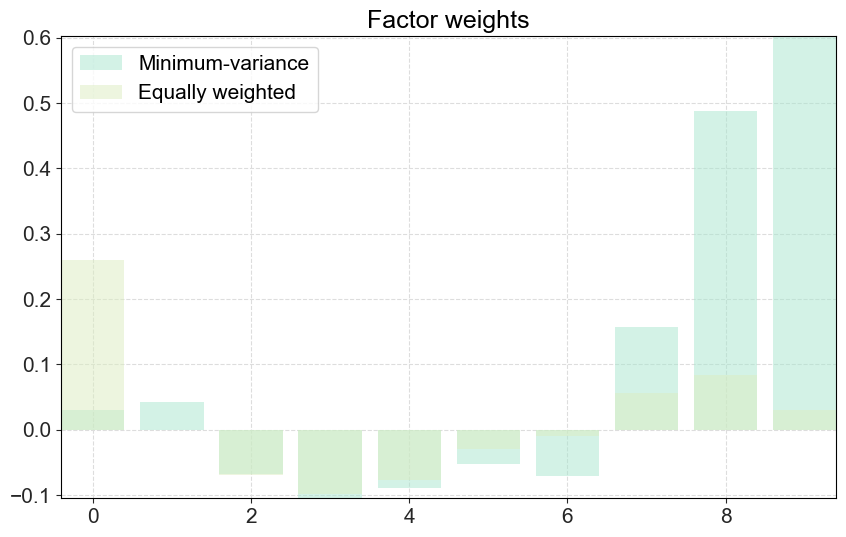

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(range(num_assets), pca_mat.T @ w_min_var, alpha=0.5, label="Minimum-variance")
ax.bar(range(num_assets), pca_mat.T @ eq_weights, alpha=0.5, label="Equally weighted")
ax.set_title("Factor weights")
ax.legend();

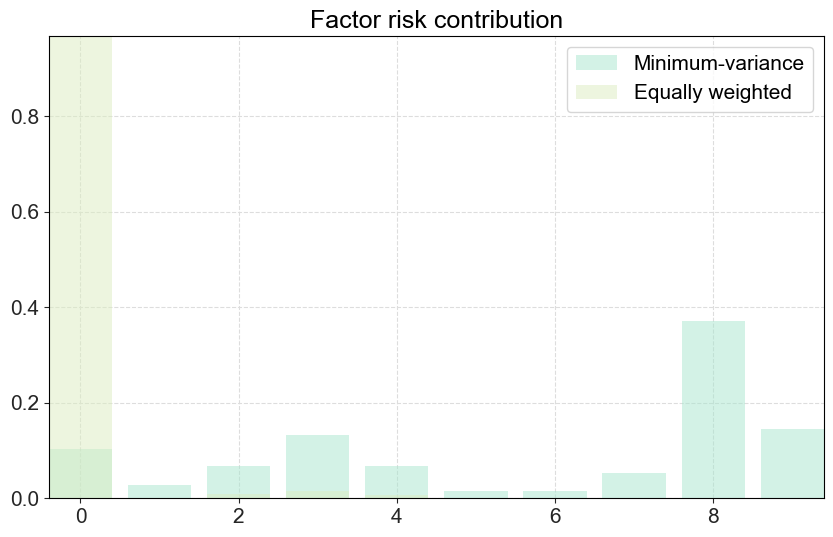

In [119]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(range(num_assets), dm.calculate_enb(w_min_var, transition_matrix=pca_mat,
                                           factor_variances=factor_variances, alpha=2)[1], alpha=0.5, label="Minimum-variance")

ax.bar(range(num_assets), dm.calculate_enb(eq_weights, transition_matrix=pca_mat,
                                           factor_variances=factor_variances, alpha=2)[1], alpha=0.5, label="Equally weighted")
ax.set_title("Factor risk contribution")
ax.legend();

__Question 4__

In [115]:
"""
Find minimum-variance portfolio 
"""

enb_target = 8.0

# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x}

number_of_bets = {'type': 'ineq',
                 'fun' : lambda x: dm.calculate_enb(x, pca_mat, factor_variances=factor_variances, alpha=2)[0] - enb_target}

# alternatively use 
bounds = [(0.0, 1.0)] * len(mu)


x0 = np.ones_like(mu) / len(mu)
res = optimize.minimize(portfolio_variance, x0=x0, args=(cov_mat,),
                        method='SLSQP',
                        constraints=[sum_to_one_cons, number_of_bets],  # no_short_cons,
                        options={'ftol': 1e-10, 'disp': True} , bounds=bounds)

w_min_var_enb = res.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.001299998265312994
            Iterations: 90
            Function evaluations: 1023
            Gradient evaluations: 90


In [116]:
w_min_var_enb.round(2)

array([0.73, 0.  , 0.  , 0.12, 0.  , 0.  , 0.  , 0.03, 0.11, 0.01])

In [117]:
w_min_var.round(2)

array([ 0.8 ,  0.  ,  0.  , -0.  , -0.  ,  0.  ,  0.  ,  0.03,  0.07,
        0.1 ])

In [118]:
dm.calculate_enb(w_min_var_enb, transition_matrix=pca_mat, factor_variances=factor_variances, alpha=2)

(7.999999999999929,
 array([0.13883027, 0.08190363, 0.08955096, 0.13659538, 0.11194516,
        0.05669121, 0.06439373, 0.0179762 , 0.20801592, 0.09409755]))

# References

## Articles

[Meucci (2009), "Managing Diversification"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1358533)

[Deguest, Martellini, Meucci, "Risk Parity and Beyond—From Asset Allocation to Risk Allocation Decisions"](https://www-pm-research-com.esc-web.lib.cbs.dk/content/iijpormgmt/early/2022/02/08/jpm20221340)
